# A simple chi analysis

Written by Simon M. Mudd at the University of Edinburgh. Updated 02/09/2021

In this example we will grab some data for a simple chi analysis. First, import the relevent modules. 

In [1]:
import lsdviztools
lsdviztools.__version__

'0.4.6'

In [2]:
pip install lsdviztools --upgrade

Note: you may need to restart the kernel to use updated packages.


In [3]:
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
import lsdviztools.lsdmapwrappers as lsdmw

## Part 1: Grab some data

We will grab some data from the Shillong Plateau in India. I use google maps to get the latitude and longitude of the southwest and northeast corners. Once you give the `ot_scraper` the corners and the type of data to download (in this case SRTM30 data), you can move on to downloading.

In [4]:
SH_DEM = bmt.ot_scraper(source = "SRTM30",
                        longitude_W = 91.271109, 
                        longitude_E = 92.214265, 
                        latitude_S = 25.107807, 
                        latitude_N = 25.627673,
                        prefix = "shillong")
SH_DEM.print_parameters()

The source is: SRTMGL1
The west longitude is: 91.271109
The east longitude is: 92.214265
The south latitude is: 25.627673
The north latitude is: 25.107807
The path is: ./
The prefix is: shillong
The resolution is: 30


Now call the download. You need to wait until the `*` symbol dissappears from the right of the line (when it stops saying `In[*]`), that indicates the download has finished. 

In [5]:
fullfname,path,fname = SH_DEM.download_pythonic()

I am going to download the following for you:
https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&south=25.107807&north=25.627673&west=91.271109&east=92.214265&outputFormat=GTiff
This might take a little while, depending on the size of the file. 
The filename will be:
./shillong_SRTMGL1.tif
The path and file without path are:
./  shillong_SRTMGL1.tif
Finished downloading


Okay, now we need to do two things. First, we need to convert to UTM. Then we need to convert to ENVI bil format. 

In [6]:
SH_DEM.to_UTM_pythonic()
RasterFile = "shillong_SRTM30_UTM.tif"
DataDirectory = "./"
gio.convert2bil(DataDirectory, RasterFile,minimum_elevation=0)

The projections is:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
And some extra projection information strings:
None
WGS 84
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 3395, 'height': 1872, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777778146, 0.0, 91.27097222225814,
       0.0, -0.0002777777777778146, 25.627916666662117)}
res tuple is:
(30.0, 30.0)
The destination CRS is: EPSG:32646
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 3182, 'height': 1950, 'count': 1, 'crs': CRS.from_epsg(32646), 'transform': Affine(30.0, 0.0, 325659.9621538402,
       0.0, -30.0, 2835612.1644070437)}
Removing pixels with an elevation less than 0


Okay, we now have an ENVI bil DEM. We are ready to start doing topographic analysis!

## Part 2, get some basin outlets

I want to extract some specific basins. I will get the lat-long of their outlets to select them (use *What's here* on google maps. I then create a csv containing the latitude and longitude using pandas. 

In [7]:
import pandas as pd

In [8]:
d = {'latitude': [25.187265,25.178305,25.176887,25.183027], 
     'longitude': [92.016604,91.756626,91.633770,91.378109]}
df = pd.DataFrame(data=d)
print(df)

    latitude  longitude
0  25.187265  92.016604
1  25.178305  91.756626
2  25.176887  91.633770
3  25.183027  91.378109


In [9]:
df.to_csv("basin_outlets.csv",index=False)

## Part 3: Running the analysis

In [10]:
lsdtt_parameters = {"write_hillshade" : "true", 
                    "get_basins_from_outlets" : "true", 
                    "basin_outlet_csv" : "basin_outlets.csv", 
                    "search_radius_nodes" : "15",
                    "convert_csv_to_geojson" : "true",
                    "print_basin_raster" : "true",
                    "print_chi_data_maps" : "true"}

In [11]:
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = "shillong_SRTM30_UTM",
                                 write_prefix= "shillong_SRTM30_UTM",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()

The lsdtopotools command line tools available are: 
['lsdtt-basic-metrics', 'lsdtt-channel-extraction', 'lsdtt-chi-mapping', 'lsdtt-cosmo-tool', 'lsdtt-hillslope-channel-coupling']
Please note only lsdtt-basic-metrics has been fully tested
The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: shillong_SRTM30_UTM
The write prefix is: shillong_SRTM30_UTM
The parameter dictionary is:
{'write_hillshade': 'true', 'get_basins_from_outlets': 'true', 'basin_outlet_csv': 'basin_outlets.csv', 'search_radius_nodes': '15', 'convert_csv_to_geojson': 'true', 'print_basin_raster': 'true', 'print_chi_data_maps': 'true'}


In [12]:
lsdtt_drive.run_lsdtt_command_line_tool()

Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.
|| Welcome to the LSDTopoTools basic metrics tool!     ||
|| This program has a number of options for calculating||
|| simple landscape metrics.                           ||
|| This program was developed by Simon M. Mudd         ||
||  at the University of Edinburgh                     ||
|| If you use these routines please cite:              ||
|| https://www.doi.org/10.5281/zenodo.2560223          ||
|| If you use the roughness routine please cite:       ||
|| https://www.doi.org/10.5194/esurf-3-483-2015        ||
|| Documentation can be found at:                      ||
|| https://lsdtopotools.github.io/LSDTT_documentation/ ||
|| You have called an LSDTopoTools program.            ||
|| Prepare to explore topographic data!                ||
|| You can read the documentation at:                  ||
I have one argument. I don't know if this is a directory path
or a driver filename. I am going 

I am going to print the basins for you. 
The filename is ./shillong_SRTM30_UTM_AllBasins.bil
Finished with exporting basins!
I am going to print some simple chi data maps for visualisation.
These data maps are also useful for visualising channel networks and making channel profiles.
I have opened the csv file.
This header is: latitude
The latitude index is: 0
This header is: longitude
The longitude index is: 1
This header is: chi
This header is: elevation
This header is: flow_distance
This header is: drainage_area
This header is: source_key
This header is: basin_key
Finished with basins
Done with channel extraction
I'm all finished! Have a nice day.


## Part 4: Plotting the data

First, lets just see where we are.

In [13]:
DataDirectory = "./"
Base_file = "shillong_SRTM30_UTM"  
fig = lsdmw.SimpleHillshade(DataDirectory,Base_file,cmap="gist_earth", save_fig=False)

Your colourbar will be located: right
xsize: 3182 and y size: 1950
NoData is: -9999.0
Yoyoyoyo the EPSG is :EPSG:32646
EPSG:32646
The EPSGString is: EPSG:32646
minimum values are x: 325659.0 and y: 2777112.0
I made the ticks.
x labels are: 
['330', '340', '350', '360', '370', '380', '390', '400', '410']
x locations are:
[330000.0, 340000.0, 350000.0, 360000.0, 370000.0, 380000.0, 390000.0, 400000.0, 410000.0]
y labels are: 
['2780', '2790', '2800', '2810', '2820', '2830']
y locations are:
[2780000.0, 2790000.0, 2800000.0, 2810000.0, 2820000.0, 2830000.0]
This colourmap is: gray


/usr/local/lib/python3.8/site-packages/lsdviztools/lsdmapfigure/plottingraster.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.tick_x_labels)
/usr/local/lib/python3.8/site-packages/lsdviztools/lsdmapfigure/plottingraster.py:423: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.tick_y_labels)


The number of axes are: 1
Axes(0,0;1x1)
Axes(0,0;1x1)
N axes are: 1
Axes(0,0;1x1)
xsize: 3182 and y size: 1950
NoData is: -9999.0
Yoyoyoyo the EPSG is :EPSG:32646
EPSG:32646
The EPSGString is: EPSG:32646
I am going to use the normalisation None
I am using the full range of values in the raster.
The number of axes are: 2
The aspect ratio is: 1.6317948717948718
I need to adjust the spacing of the colourbar.
You have a colourbar on the left or right, I need to check the number of characters in the labels.
['', '']
The longest colourbar label has 0 characters.
The cbar characters are: 0 and the cbar text width is: 0.4
cbar_left: 4.1212599999999995 map left: 0.8500000000000001
cbar_bottom: 0.65 map bottom: 0.65
The figure size is: 
[4.92126, 2.7934182903834066]
Map axes are:
[0.1727199944729602, 0.23268982029568697, 0.6444000113791996, 0.6957133119210247]
cbar_axes are:
[0.8374400052019197, 0.23268982029568697, 0.04063999869952004, 0.6957133119210247]
Number of axes are: 2
I'm returning:
Fi

/usr/local/lib/python3.8/site-packages/lsdviztools/lsdmapfigure/plottingraster.py:1169: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(im,cmap=BaseRaster._colourmap,spacing='uniform', orientation=self.colourbar_orientation,cax=ax_list[-1],drawedges=False)


In [14]:
fig.show()

<img src="shillong_SRTM30_UTM_hillshade.png" width=600>

Now plot the channels

In [15]:
ChannelFileName = "shillong_SRTM30_UTM_chi_data_map.csv"
channel_img = lsdmw.PrintChannels(DataDirectory,Base_file,ChannelFileName, 
                               cmap = "gist_earth",
                               size_format = "geomorphology", dpi = 300, 
                               plotting_column = "basin_key", save_fig = False)

Let me get the point data
The filename is: ./shillong_SRTM30_UTM_chi_data_map.csv
The object file prefix is: shillong_SRTM30_UTM_chi_data_map
Loading your file from csv
done
The parameter names are
['latitude', 'longitude', 'chi', 'elevation', 'flow_distance', 'drainage_area', 'source_key', 'basin_key']
Your colourbar will be located: None
xsize: 3182 and y size: 1950
NoData is: -9999.0
Yoyoyoyo the EPSG is :EPSG:32646
EPSG:32646
The EPSGString is: EPSG:32646
minimum values are x: 325659.0 and y: 2777112.0
I made the ticks.
x labels are: 
['330', '340', '350', '360', '370', '380', '390', '400', '410']
x locations are:
[330000.0, 340000.0, 350000.0, 360000.0, 370000.0, 380000.0, 390000.0, 400000.0, 410000.0]
y labels are: 
['2780', '2790', '2800', '2810', '2820', '2830']
y locations are:
[2780000.0, 2790000.0, 2800000.0, 2810000.0, 2820000.0, 2830000.0]
This colourmap is: gray
The number of axes are: 1
Axes(0,0;1x1)
Axes(0,0;1x1)
N axes are: 1
Axes(0,0;1x1)
xsize: 3182 and y size: 1950


In [16]:
channel_img.show()

<img src="shillong_SRTM30_UTM_channels_coloured_by_basin.png" width=600>

Now show the basins and the channels

In [17]:
basin_img = lsdmw.PrintChannelsAndBasins(DataDirectory,Base_file,
                                              add_basin_labels = True, 
                                              cmap = "jet",  
                                              size_format = "geomorphology", dpi = 300, save_fig=False)

Basin keys are: 
[0, 1, 2, 3]
I'm going to make the basin plots. Your topographic data must be in ENVI bil format or I'll break!!
shillong_SRTM30_UTM_AllBasins.bil
shillong_SRTM30_UTM_AllBasins.bil
Let me grab the coordinate reference system.
EPSG:32646
I need to convert the crs to wkt format so it is resistant to stupid proj errors.
ID is: 945.0
ID is: 655.0
ID is: 786.0
ID is: 1536.0
The object file prefix is: shillong_SRTM30_UTM_chi_data_map
Loading your file from csv
done
I am showing the basins without text labels.
Your colourbar will be located: None
xsize: 3182 and y size: 1950
NoData is: -9999.0
Yoyoyoyo the EPSG is :EPSG:32646
EPSG:32646
The EPSGString is: EPSG:32646
minimum values are x: 325659.0 and y: 2777112.0
I made the ticks.
x labels are: 
['330', '340', '350', '360', '370', '380', '390', '400', '410']
x locations are:
[330000.0, 340000.0, 350000.0, 360000.0, 370000.0, 380000.0, 390000.0, 400000.0, 410000.0]
y labels are: 
['2780', '2790', '2800', '2810', '2820', '2830'

In [18]:
basin_img.show()

<img src="shillong_SRTM30_UTM_channels_with_basins.png" width=800>

In [19]:
basin2_img_name = lsdmw.PrintBasins_Complex(DataDirectory,Base_file,
                                           use_keys_not_junctions = True, 
                                           show_colourbar = False,cmap = "jet", 
                                           colorbarlabel = "colourbar", size_format = "geomorphology",
                                           fig_format = "png", dpi = 250, 
                                           include_channels = False, label_basins = True)

Basin keys are: 
[0, 1, 2, 3]
I'm going to make the basin plots. Your topographic data must be in ENVI bil format or I'll break!!
Your colourbar will be located: None
xsize: 3182 and y size: 1950
NoData is: -9999.0
Yoyoyoyo the EPSG is :EPSG:32646
EPSG:32646
The EPSGString is: EPSG:32646
minimum values are x: 325659.0 and y: 2777112.0
I made the ticks.
x labels are: 
['330', '340', '350', '360', '370', '380', '390', '400', '410']
x locations are:
[330000.0, 340000.0, 350000.0, 360000.0, 370000.0, 380000.0, 390000.0, 400000.0, 410000.0]
y labels are: 
['2780', '2790', '2800', '2810', '2820', '2830']
y locations are:
[2780000.0, 2790000.0, 2800000.0, 2810000.0, 2820000.0, 2830000.0]
This colourmap is: gray
The number of axes are: 1
Axes(0,0;1x1)
Axes(0,0;1x1)
shillong_SRTM30_UTM_AllBasins.bil
Let me grab the coordinate reference system.
EPSG:32646
I need to convert the crs to wkt format so it is resistant to stupid proj errors.
ID is: 945.0
ID is: 655.0
ID is: 786.0
ID is: 1536.0
The num

<img src="shillong_SRTM30_UTM_selected_basins.png" width=800>

In [33]:
basin2_profile_name = lsdmw.SimpleProfile(DataDirectory,Base_file, size_format = "ESURF", fig_format = "png", dpi = 250, basin_key=[0], source_key=[0])

In [34]:
print(basin2_profile_name)

./shillong_SRTM30_UTM_profiles.png


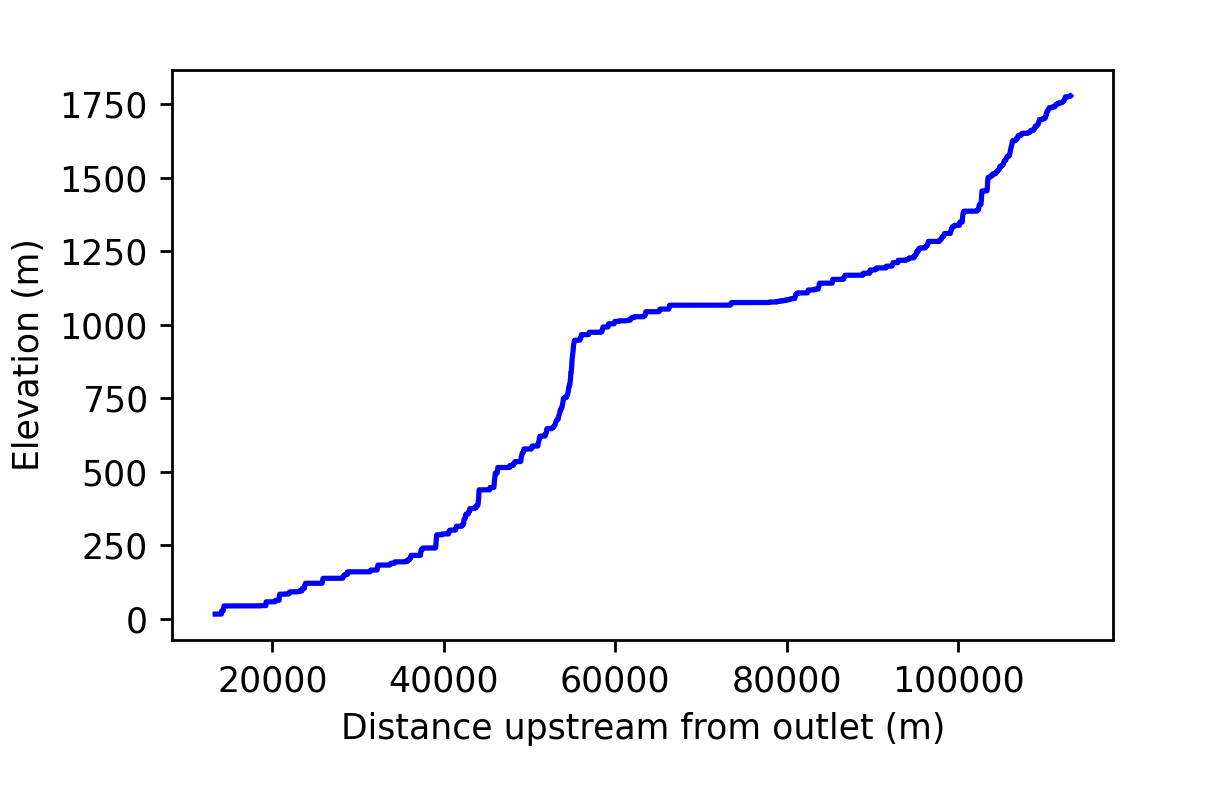

In [35]:
from IPython.display import Image
Image(filename=basin2_profile_name,width=800) 